# Decision Trees
> Decision trees are a supervised ML method used for classification and regression tasks.
> A decision tree consists of multiple nodes. At each node one feature at a time is tested. Based on the result the example traverses to the next node until a leaf node is reached. The leaf node is the class label or the value of the target variable.
>Decision trees test the most important features first. 
 
## Feature importance - Entropy
- Most important features are those with the highest information gain / impact on the target variable.
- Entropy is a measure of the amount of uncertainty in the data
- Entropy is 0 if all members of a set belong to the same class, i.e. no uncertainty
- Entropy is 1 if a set is equally divided between classes, i.e. maximum uncertainty

Entropy of a training set $H$ is defined as: $$H(Output) = B(\frac{p}{p+n})$$
- where $p$ is the number of positive examples and 
- $n$ is the number of negative examples. 
- $B$ is the binary entropy function: $$B(q) = -(q\log_2q + (1-q)\log_2(1-q))$$

## Decision Tree learning
- Greedy divide and conquer algorithm: Test most important feature first, then solve sub-problems
- Tree construction
    - If all examples are of the same class, done
    - If remaining examples are of mixed class, choose best feature to split on
    - No examples left, done (return most common class used in parent node)
    - No attributes left but examples are not pure, done (return most common class used in parent node)

In [28]:
import numpy as np
from typing import List
from typing import Tuple
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [29]:
iris = datasets.load_iris()
X_train = iris.data
y_train = iris.target

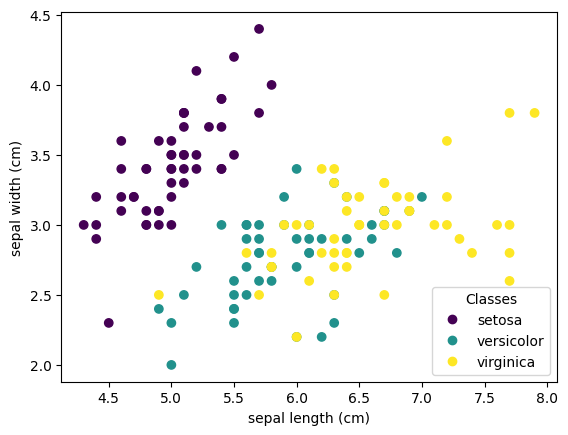

In [30]:
_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

$$p_{mk} = \frac{1}{n_m} \sum_{y \in Q_m} I(y = k)$$
- $p_{mk}$ is the proportion of class $k$ observations in node $m$
- $n_m$ is the total number of observations in node $m$
- $Q_m$ is the set of training observations in node $m$
- $I$ indicator function $\begin{cases} 1 & \text{ if } y = k \\ 0 & \text{ otherwise} \end{cases}$

In [31]:
def proportion_of_observations(y: List[int], class_k: int) -> float:
    """
    Calculates the probability of each class in the given label vector.
    Based on the formula: $$p_{mk} = \frac{1}{n_m} \sum_{y \in Q_m} I(y = k)$$ from https://scikit-learn.org/stable/modules/tree.html
    :param y: Label vector (Q_m).
    :param class_k: Class to calculate the probability for.
    :return: Proportion of observations for the class_k in the given label vector.
    """
    occurrences = 0
    for curr_y in y:
        if curr_y == class_k:
            occurrences += 1
    return occurrences / len(y)

$$H(Q_m) = - \sum_{k=1}^K p_{mk} \log_2 p_{mk}$$
- $H(Q_m)$ is the entropy of node $m$
- $K$ is the number of classes

In [32]:
def entropy(probabilities: list[float]) -> float:
    """
    Calculates the entropy of the given feature.
    Based on the formula: $$H(Q_m) = - \sum_{k=1}^K p_{mk} \log_2 p_{mk}$$ from https://scikit-learn.org/stable/modules/tree.html
    :param probabilities: Probabilities of each class in the given label vector.
    :return: Entropy of the given feature.
    """
    sum_e = 0.0
    for k in range(len(probabilities)):
        sum_e += probabilities[k] * np.log(probabilities[k])
    return -sum_e

In [33]:
class CandidateSplit:
    decision_boundary: float
    feature_index: int
    entropy: float
    
    def __init__(self, decision_boundary: float, feature_index: int, entropy_costs: float):
        self.decision_boundary = decision_boundary
        self.feature_index = feature_index
        self.entropy = entropy_costs
        
    def __str__(self):
        return f"Decision boundary: {self.decision_boundary}, feature index: {self.feature_index}, entropy: {self.entropy}"
        
class FeatureSpace:
    X: List[List[float]]
    y: List[int]
    
    def __init__(self, X: List[List[float]], y: List[int]):
        self.X = X
        self.y = y
    
    def is_all_of_same_class(self):
        return len(set(self.y)) == 1
    
    def __str__(self):
        return f"X: {self.X}, y: {self.y}"

class DecisionTreeNode:
    candidate_split: CandidateSplit
    feature_space: FeatureSpace
    left_child: 'DecisionTreeNode'
    right_child: 'DecisionTreeNode'

    def __init__(self, candidate_split: CandidateSplit, feature_space: FeatureSpace):
        self.candidate_split = candidate_split
        self.feature_space = feature_space
        self.left_child = None
        self.right_child = None
        
    
    def decide(self, x: list[float]) -> int:
        if self.left_child is not None and x[self.candidate_split.feature_index] < self.candidate_split.decision_boundary:
            return self.left_child.decide(x)
        elif self.right_child is not None:
                return self.right_child.decide(x)
        elif self.feature_space.is_all_of_same_class():
            return self.feature_space.y[0]
        else:
            return self.most_common_class()

    def most_common_class(self) -> int:
        counts = [self.feature_space.y.count(c) for c in self.feature_space.y]
        return counts.index(max(counts))
    
    def __str__(self):
        return f"Candidate split: {self.candidate_split}, feature space: {self.feature_space}, left child: {self.left_child}, right child: {self.right_child}"


class DecisionTree:
    """
    Decision Tree for binary classification.
    """
    root: DecisionTreeNode

    def __init__(self):
        pass

    def train(self, X: List[List[float]], y: List[int]):
        feature_space = FeatureSpace(X, y)
        self.root = DecisionTreeNode(self.candidate_split_selection(feature_space), feature_space)
        open_paths = [self.root]
        while len(open_paths) > 0:
            current_node = open_paths.pop()
            # If all examples are of the same class, dont split
            if current_node.feature_space.is_all_of_same_class():
                print("All examples are of the same class, dont split")
                continue
            # If remaining examples are of mixed class, split continue to split
            (left_split_feature_space, right_split_feature_space) = self.split(current_node.feature_space, current_node.candidate_split.feature_index, current_node.candidate_split.decision_boundary)
            if len(left_split_feature_space.X) > 0:
                split = self.candidate_split_selection(left_split_feature_space)
                n = DecisionTreeNode(split, left_split_feature_space)
                current_node.left_child = n
                open_paths.append(n)
            if len(right_split_feature_space.X) > 0:
                split = self.candidate_split_selection(right_split_feature_space)
                n = DecisionTreeNode(split, right_split_feature_space)
                current_node.right_child = n
                open_paths.append(n)
    
    @staticmethod
    def split(feature_space: FeatureSpace, feature_index: int, decision_boundary: float) -> Tuple[FeatureSpace, FeatureSpace]:
        left_split = FeatureSpace([], [])
        right_split = FeatureSpace([], [])
        for (index, row) in enumerate(feature_space.X):
            if row[feature_index] <= decision_boundary:
                left_split.X.append(feature_space.X[index])
                left_split.y.append(feature_space.y[index])
            else:
                right_split.X.append(feature_space.X[index])
                right_split.y.append(feature_space.y[index])
        return left_split, right_split
    
    def candidate_split_selection(self, feature_space: FeatureSpace) -> CandidateSplit:
        possible_splits: list[CandidateSplit] = []
        for feature_index in range(len(feature_space.X[0])):
            for row in feature_space.X:
                decision_boundary = row[feature_index]
                entropy_costs = self.get_weighted_entropy(feature_space, feature_index, decision_boundary)
                possible_splits.append(CandidateSplit(decision_boundary, feature_index, entropy_costs))
        return min(possible_splits, key=lambda split: split.entropy)

    def predict(self, x: list[float]) -> int:
        return self.root.decide(x)

    @staticmethod
    def get_weighted_entropy(feature_space: FeatureSpace, feature_index: int, decision_boundary: int):
        """
        Calculates the entropy of the given feature.
        :param feature_space: 
        :param feature_index: Index of the feature to calculate the entropy for.
        :param decision_boundary: Decision boundary for the given feature.
        :return: The entropy of the given feature.
        """
        (left_split, right_split) = DecisionTree.split(feature_space, feature_index, decision_boundary)
        left_proportions = [proportion_of_observations(left_split.y, curr_class) for curr_class in set(left_split.y)]
        right_proportions = [proportion_of_observations(right_split.y, curr_class) for curr_class in set(right_split.y)]
        entropy_left = entropy(left_proportions)
        entropy_right = entropy(right_proportions)
        weighted_entropy = (len(left_split.y) / len(feature_space.y)) * entropy_left + (len(right_split.y) / len(feature_space.y)) * entropy_right
        return weighted_entropy

In [34]:
decision_tree = DecisionTree()
decision_tree.train(X_train, y_train)

All examples are of the same class, dont split
All examples are of the same class, dont split
All examples are of the same class, dont split
All examples are of the same class, dont split
All examples are of the same class, dont split
All examples are of the same class, dont split
All examples are of the same class, dont split
All examples are of the same class, dont split
All examples are of the same class, dont split


In [35]:
def print_tree(node: DecisionTreeNode, indent: int = 0):
    if node is None:
        return
    print(" " * indent + f"Decision boundary: {node.candidate_split.decision_boundary}, feature index: {node.candidate_split.feature_index}, entropy: {node.candidate_split.entropy}")
    print_tree(node.left_child, indent + 2)
    print_tree(node.right_child, indent + 2)
print_tree(decision_tree.root)

Decision boundary: 1.9, feature index: 2, entropy: 0.46209812037329684
  Decision boundary: 5.1, feature index: 0, entropy: -0.0
  Decision boundary: 1.7, feature index: 3, entropy: 0.2147644654371359
    Decision boundary: 4.9, feature index: 2, entropy: 0.1607369676476831
      Decision boundary: 1.6, feature index: 3, entropy: -0.0
        Decision boundary: 7.0, feature index: 0, entropy: -0.0
        Decision boundary: 4.9, feature index: 0, entropy: -0.0
      Decision boundary: 1.5, feature index: 3, entropy: 0.3182570841474064
        Decision boundary: 6.0, feature index: 0, entropy: -0.0
        Decision boundary: 6.7, feature index: 0, entropy: -0.0
          Decision boundary: 6.7, feature index: 0, entropy: -0.0
          Decision boundary: 7.2, feature index: 0, entropy: -0.0
    Decision boundary: 4.8, feature index: 2, entropy: 0.04151179358444431
      Decision boundary: 5.9, feature index: 0, entropy: -0.0
        Decision boundary: 5.9, feature index: 0, entropy: -0.

In [36]:
for (index, feature_name) in enumerate(iris.feature_names):
    print(f"{index}: {feature_name}")

0: sepal length (cm)
1: sepal width (cm)
2: petal length (cm)
3: petal width (cm)


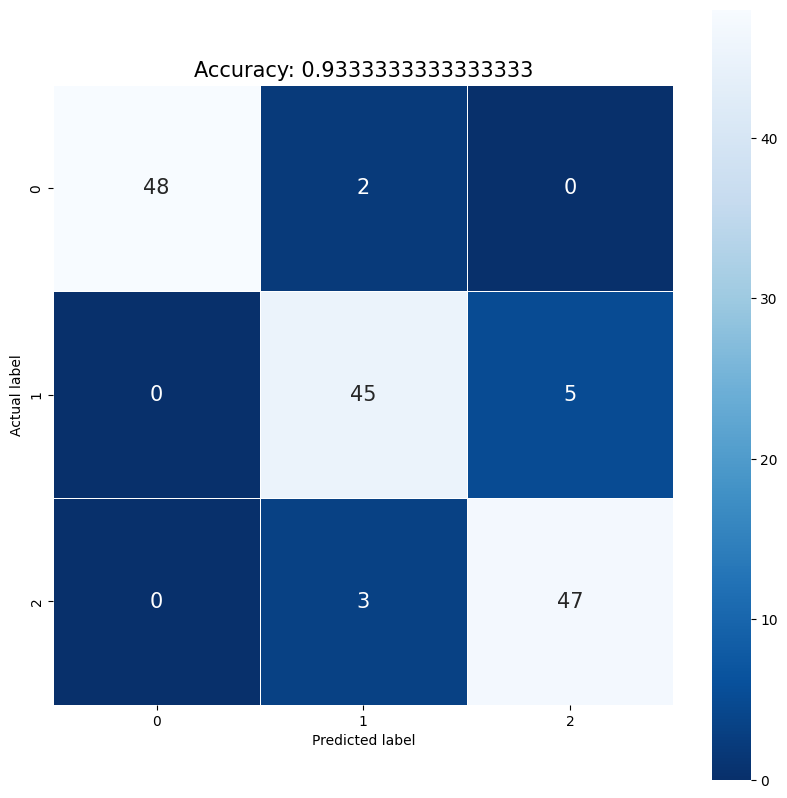

In [37]:
preds = [decision_tree.predict(x) for x in X_train]

# Plot confusion matrix
cm = confusion_matrix(y_train, preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r', annot_kws={"size": 15})
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f"Accuracy: {accuracy_score(y_train, preds)}", size = 15)
plt.show()